# GNN-based URA Clustering

This notebook trains a Graph Neural Network to cluster a $16 \times 16$ antenna array.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

from gnn import (
    URAConfig,
    create_ura_graph,
    compute_mutual_coupling,
    train_ura_clustering,
    assignments_to_antenna_format,
)

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

c:\Users\Andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.9.1+cpu
CUDA: False


In [2]:
# --- Checkpoint utilities ---
import json as _json
import os as _os
from datetime import datetime as _datetime

_CHECKPOINT_DIR = _os.path.normpath(_os.path.join(_os.path.abspath('.'), '..', 'intermediate_steps'))
_os.makedirs(_CHECKPOINT_DIR, exist_ok=True)

def _to_serializable(obj):
    """Convert numpy/torch types to Python native types."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if hasattr(obj, 'item'):
        return obj.item()
    return obj

def _convert(d):
    """Recursively convert all values in a dict/list to JSON-serializable types."""
    if isinstance(d, dict):
        return {k: _convert(v) for k, v in d.items()}
    if isinstance(d, (list, tuple)):
        return [_convert(x) for x in d]
    return _to_serializable(d)

def _build_config_step(config_obj, num_clusters, ele0=0, azi0=0, SLL_level=20, SLLin=15):
    """Build a config step dict from URAConfig and params."""
    return {
        "rows": config_obj.rows, "cols": config_obj.cols,
        "dx": config_obj.dx, "dy": config_obj.dy,
        "freq_ghz": config_obj.freq / 1e9, "num_clusters": num_clusters,
        "ele0": ele0, "azi0": azi0, "SLL_level": SLL_level, "SLLin": SLLin,
    }

def _build_training_step(cluster_assignments, cluster_sizes, epochs, mode="simple"):
    """Build a training step dict."""
    return {
        "cluster_assignments": cluster_assignments,
        "cluster_sizes": cluster_sizes,
        "epochs": epochs, "mode": mode,
    }

def _build_radiation_step(result, metrics, array_obj=None):
    """Build a radiation step dict from evaluation result and lobe metrics."""
    step = {
        "Cm": result['Cm'], "clustering_factor": result['clustering_factor'],
        "sll_out": result['sll_out'], "sll_in": result['sll_in'],
        "main_lobe_gain": metrics['main_lobe_gain'],
        "hpbw_ele": metrics['hpbw_ele'], "hpbw_azi": metrics['hpbw_azi'],
        "sll_ele_relative": metrics['sll_ele_relative'],
        "sll_azi_relative": metrics['sll_azi_relative'],
        "n_lobes_ele": metrics['n_lobes_ele'], "n_lobes_azi": metrics['n_lobes_azi'],
        "ele_cut": metrics['ele_cut'], "azi_cut": metrics['azi_cut'],
    }
    if array_obj is not None:
        step["ele_angles"] = array_obj.ele
        step["azi_angles"] = array_obj.azi
        step["FF_I_dB"] = result['FF_I_dB']
        step["G_boresight"] = result['G_boresight']
    return step

def save_checkpoint(filename, notebook, case_name, description, steps):
    """Save checkpoint to JSON in intermediate_steps directory."""
    filepath = _os.path.join(_CHECKPOINT_DIR, filename)
    checkpoint = {
        "notebook": notebook,
        "case_name": case_name,
        "description": description,
        "timestamp": _datetime.now().isoformat(),
        "steps": _convert(steps),
    }
    with open(filepath, 'w') as f:
        _json.dump(checkpoint, f)
    print(f"Checkpoint saved: {filepath}")

print(f"Checkpoint dir: {_CHECKPOINT_DIR}")

Checkpoint dir: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps


## 1. Configuration

In [3]:
config = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)

print(f"Array: {config.N} elements")
print(f"Spacing: dx={config.dx}λ, dy={config.dy}λ")

Array: 256 elements
Spacing: dx=0.5λ, dy=0.7λ


## 2. Train GNN (Physics-Informed)

Uses mutual coupling and targets a clustering factor of ~3.

In [4]:
target_cf = 2.0

print(f"Training GNN (physics-informed, target CF={target_cf})...\n")
clusters = train_ura_clustering(
    config,
    target_cf=target_cf,
    epochs=2000,
    verbose=True
)

num_clusters = len(np.unique(clusters))
sizes = np.bincount(clusters)
print(f"\nActive clusters: {num_clusters}")
print(f"Clustering factor: {config.N / num_clusters:.2f}")
print(f"Cluster sizes: min={sizes.min()}, max={sizes.max()}, mean={sizes.mean():.1f}")

Training GNN (physics-informed, target CF=2.0)...

Epoch 100: Loss=1.6120 T=4.68 | clusters=101, CF=2.53, sizes: min=1, max=7, mean=2.5 | cut=-0.891, cf=0.000, bal=0.005
Epoch 200: Loss=1.6186 T=4.36 | clusters=110, CF=2.33, sizes: min=1, max=6, mean=2.3 | cut=-0.856, cf=0.000, bal=0.005
Epoch 300: Loss=1.6296 T=4.04 | clusters=111, CF=2.31, sizes: min=1, max=7, mean=2.3 | cut=-0.829, cf=0.000, bal=0.006
Epoch 400: Loss=1.6384 T=3.72 | clusters=110, CF=2.33, sizes: min=1, max=6, mean=2.3 | cut=-0.795, cf=0.000, bal=0.006
Epoch 500: Loss=1.6649 T=3.40 | clusters=111, CF=2.31, sizes: min=1, max=5, mean=2.3 | cut=-0.756, cf=0.000, bal=0.006
Epoch 600: Loss=1.7054 T=3.07 | clusters=112, CF=2.29, sizes: min=1, max=6, mean=2.3 | cut=-0.694, cf=0.000, bal=0.006
Epoch 700: Loss=1.7534 T=2.75 | clusters=117, CF=2.19, sizes: min=1, max=5, mean=2.2 | cut=-0.636, cf=0.000, bal=0.007
Epoch 800: Loss=1.9880 T=2.43 | clusters=97, CF=2.64, sizes: min=1, max=10, mean=2.6 | cut=-0.393, cf=0.000, bal=0.0

## 3. Visualize Results

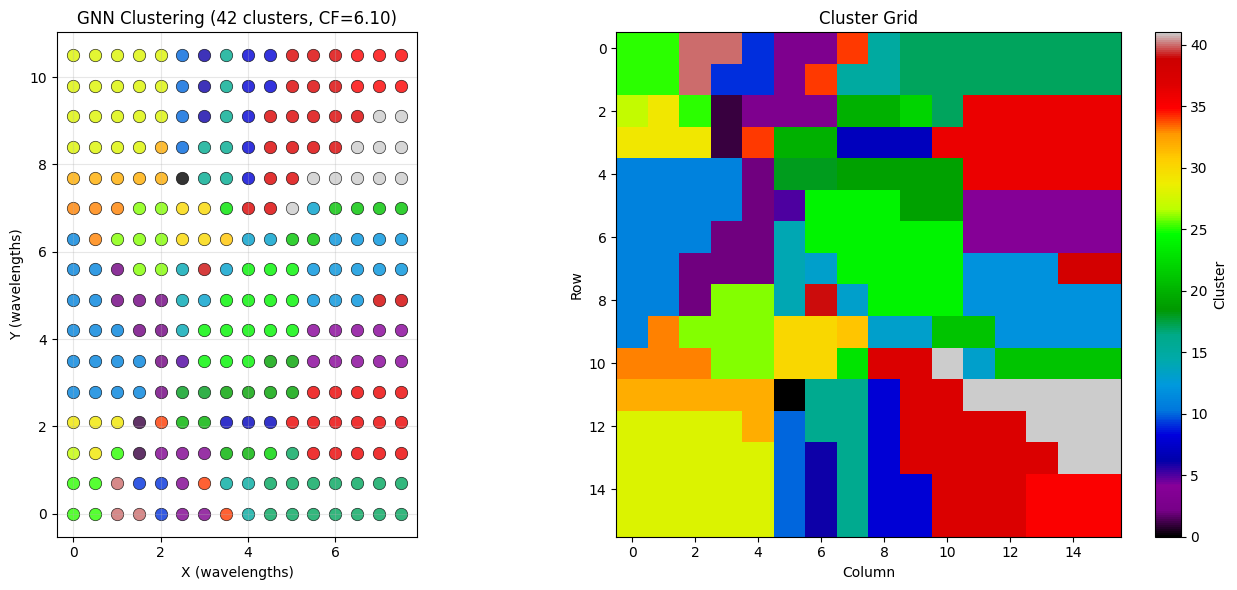

In [5]:
# Get positions
positions, _, _, _ = create_ura_graph(config, use_coupling=False)
pos_np = positions.numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
cmap = plt.cm.nipy_spectral if num_clusters > 20 else plt.cm.tab20 if num_clusters > 10 else plt.cm.tab10
colors = cmap(np.linspace(0, 1, num_clusters))

for k in range(num_clusters):
    mask = clusters == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np[mask, 0], pos_np[mask, 1],
                        c=[colors[k % len(colors)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'GNN Clustering ({num_clusters} clusters, CF={config.N/num_clusters:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Grid view
grid = clusters.reshape(config.rows, config.cols)
im = axes[1].imshow(grid, cmap='nipy_spectral' if num_clusters > 10 else 'tab10',
                    vmin=0, vmax=num_clusters-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

## 5. Radiation Pattern (if available)

=== GNN Physics-Informed - Radiation Pattern ===


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


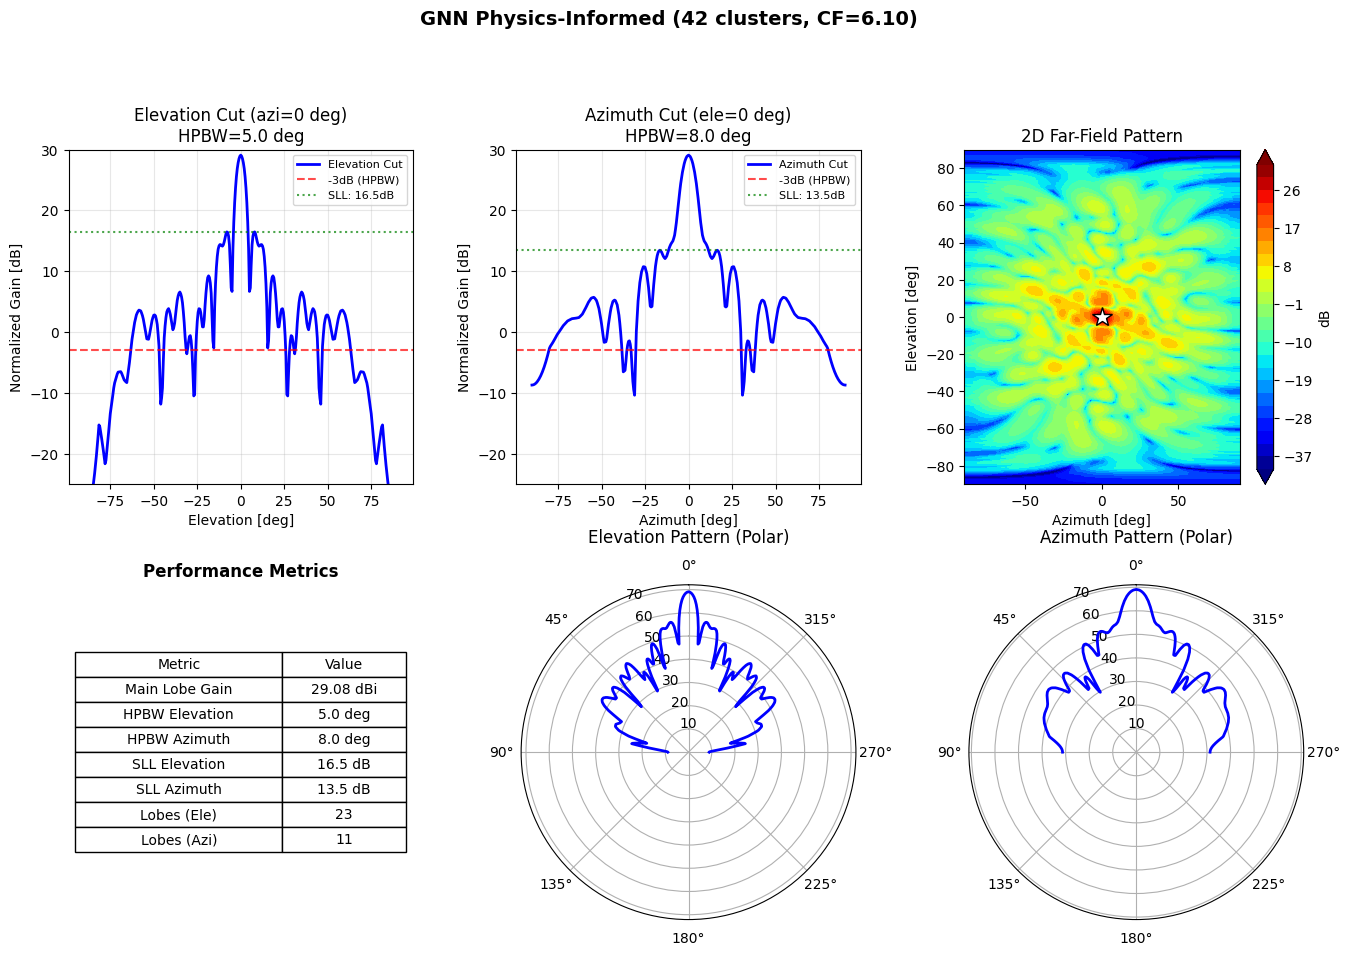


RESULTS:
  Clusters: 42, CF: 6.10
  Cm: 14.82, SLL_out: -21.70dB, SLL_in: -14.02dB
  Hardware reduction: 83.6%


In [6]:
from matplotlib.gridspec import GridSpec
from scipy.signal import find_peaks
sys.path.insert(0, '../optimization/pyvers')
from antenna_physics import LatticeConfig, SystemConfig, MaskConfig, ElementPatternConfig, AntennaArray


def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    ele_idx = np.argmin(np.abs(ele - ele0))
    azi_idx = np.argmin(np.abs(azi - azi0))
    ele_cut = FF_I_dB[:, azi_idx]
    azi_cut = FF_I_dB[ele_idx, :]
    main_lobe_gain = G_boresight if G_boresight else np.max(FF_I_dB)
    def find_hpbw(cut, angles):
        max_idx = np.argmax(cut)
        threshold = cut[max_idx] - 3
        left_idx = max_idx
        for i in range(max_idx, -1, -1):
            if cut[i] < threshold:
                left_idx = i
                break
        right_idx = max_idx
        for i in range(max_idx, len(cut)):
            if cut[i] < threshold:
                right_idx = i
                break
        return angles[right_idx] - angles[left_idx]
    hpbw_ele = find_hpbw(ele_cut, ele)
    hpbw_azi = find_hpbw(azi_cut, azi)
    def find_sll_relative(cut, angles):
        max_val = np.max(cut)
        peaks, _ = find_peaks(cut)
        threshold = max_val - 3
        side_peaks = [p for p in peaks if cut[p] < threshold]
        if side_peaks:
            return max(cut[p] for p in side_peaks)
        return -30
    sll_ele_relative = find_sll_relative(ele_cut, ele)
    sll_azi_relative = find_sll_relative(azi_cut, azi)
    peaks_ele, _ = find_peaks(ele_cut, height=-30)
    peaks_azi, _ = find_peaks(azi_cut, height=-30)
    return {
        'main_lobe_gain': main_lobe_gain, 'hpbw_ele': hpbw_ele, 'hpbw_azi': hpbw_azi,
        'sll_ele_relative': sll_ele_relative, 'sll_azi_relative': sll_azi_relative,
        'n_lobes_ele': len(peaks_ele), 'n_lobes_azi': len(peaks_azi),
        'ele_cut': ele_cut, 'azi_cut': azi_cut,
    }


def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None, title="Lobe Analysis"):
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi
    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ele, metrics['ele_cut'], 'b-', linewidth=2, label='Elevation Cut')
    ax1.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax1.axhline(y=metrics['sll_ele_relative'], color='g', linestyle=':', alpha=0.7,
                label=f"SLL: {metrics['sll_ele_relative']:.1f}dB")
    ax1.set_xlabel('Elevation [deg]'); ax1.set_ylabel('Normalized Gain [dB]')
    ax1.set_title(f"Elevation Cut (azi={azi0} deg)\nHPBW={metrics['hpbw_ele']:.1f} deg")
    ax1.legend(loc='upper right', fontsize=8); ax1.grid(True, alpha=0.3); ax1.set_ylim([-25, 30])
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(azi, metrics['azi_cut'], 'b-', linewidth=2, label='Azimuth Cut')
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax2.axhline(y=metrics['sll_azi_relative'], color='g', linestyle=':', alpha=0.7,
                label=f"SLL: {metrics['sll_azi_relative']:.1f}dB")
    ax2.set_xlabel('Azimuth [deg]'); ax2.set_ylabel('Normalized Gain [dB]')
    ax2.set_title(f"Azimuth Cut (ele={ele0} deg)\nHPBW={metrics['hpbw_azi']:.1f} deg")
    ax2.legend(loc='upper right', fontsize=8); ax2.grid(True, alpha=0.3); ax2.set_ylim([-25, 30])
    ax3 = fig.add_subplot(gs[0, 2])
    levels = np.arange(-40, 35, 3)
    contour = ax3.contourf(antenna_array.AZI, antenna_array.ELE, FF_I_dB,
                           levels=levels, cmap='jet', extend='both')
    plt.colorbar(contour, ax=ax3, label='dB')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='k')
    ax3.set_xlabel('Azimuth [deg]'); ax3.set_ylabel('Elevation [deg]')
    ax3.set_title('2D Far-Field Pattern')
    ax4 = fig.add_subplot(gs[1, 0]); ax4.axis('off')
    table_data = [
        ['Main Lobe Gain', f"{metrics['main_lobe_gain']:.2f} dBi"],
        ['HPBW Elevation', f"{metrics['hpbw_ele']:.1f} deg"],
        ['HPBW Azimuth', f"{metrics['hpbw_azi']:.1f} deg"],
        ['SLL Elevation', f"{metrics['sll_ele_relative']:.1f} dB"],
        ['SLL Azimuth', f"{metrics['sll_azi_relative']:.1f} dB"],
        ['Lobes (Ele)', f"{metrics['n_lobes_ele']}"],
        ['Lobes (Azi)', f"{metrics['n_lobes_azi']}"],
    ]
    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      loc='center', cellLoc='center', colWidths=[0.5, 0.3])
    table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.2, 1.5)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    ax5.plot(np.deg2rad(ele), metrics['ele_cut'] + 40, 'b-', linewidth=2)
    ax5.set_theta_zero_location('N'); ax5.set_title('Elevation Pattern (Polar)', y=1.1)
    ax6 = fig.add_subplot(gs[1, 2], projection='polar')
    ax6.plot(np.deg2rad(azi), metrics['azi_cut'] + 40, 'b-', linewidth=2)
    ax6.set_theta_zero_location('N'); ax6.set_title('Azimuth Pattern (Polar)', y=1.1)
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    return metrics


# --- Evaluate radiation pattern ---
print("=== GNN Physics-Informed - Radiation Pattern ===")
clusters_antenna = assignments_to_antenna_format(clusters, grid_shape=(config.rows, config.cols))
lattice_init = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_init = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask_init = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef_init = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_init = AntennaArray(lattice_init, system_init, mask_init, eef_init)
result_init = array_init.evaluate_clustering(clusters_antenna)
metrics_init = plot_lobe_analysis(result_init['FF_I_dB'], array_init,
                                  G_boresight=result_init['G_boresight'],
                                  title=f"GNN Physics-Informed ({num_clusters} clusters, CF={config.N/num_clusters:.2f})")
print(f"\nRESULTS:")
print(f"  Clusters: {num_clusters}, CF: {result_init['clustering_factor']:.2f}")
print(f"  Cm: {result_init['Cm']:.2f}, SLL_out: {result_init['sll_out']:.2f}dB, SLL_in: {result_init['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters/config.N)*100:.1f}%")

In [7]:
# --- Save initial checkpoint ---
save_checkpoint("gnn_initial.json", "gnn", "initial",
    f"GNN Physics-Informed (target CF={target_cf}, boresight)",
    {
        "config": {
            "rows": config.rows, "cols": config.cols,
            "dx": config.dx, "dy": config.dy,
            "freq_ghz": config.freq / 1e9, "target_cf": target_cf,
            "num_clusters": num_clusters,
            "ele0": 0, "azi0": 0, "SLL_level": 20, "SLLin": 15,
        },
        "training": {
            "cluster_assignments": clusters,
            "cluster_sizes": sizes.tolist(),
            "num_clusters": num_clusters,
            "clustering_factor": config.N / num_clusters,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_init, metrics_init, array_init),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_initial.json


# Test Cases Section

The following cells implement test cases with the following common parameters:
- **Frequency**: 29.5 GHz
- **Element pattern**: cos(ele)*cos(azi) (P=1)
- **N**: 256 elements (16x16 array)
- **Vertical spacing**: 0.7 lambda
- **Horizontal spacing**: 0.5 lambda

The GNN discovers the optimal number of clusters to achieve the target clustering factor.

## Case 0: theta=0 deg, phi=0 deg, target CF=2, SLL<-20dB, sizes {1,2,4}

CASE 0: theta=0 deg, phi=0 deg, target CF=2, SLL<-20dB, sizes {1,2,4}
Array: 256 elements
Target CF: 2.0
Allowed cluster sizes: [1, 2, 4]

Training GNN (physics-informed, allowed_sizes=[1,2,4])...
Epoch 100: Loss=5.1901 T=4.68 | clusters=144, CF=1.78, sizes: min=1, max=7, mean=1.8 | cut=-0.900, cf=0.227, bal=0.111
Epoch 200: Loss=5.2052 T=4.36 | clusters=137, CF=1.87, sizes: min=1, max=5, mean=1.9 | cut=-0.881, cf=0.227, bal=0.111
Epoch 300: Loss=5.2474 T=4.04 | clusters=132, CF=1.94, sizes: min=1, max=6, mean=1.9 | cut=-0.833, cf=0.227, bal=0.112
Epoch 400: Loss=5.2482 T=3.72 | clusters=142, CF=1.80, sizes: min=1, max=5, mean=1.8 | cut=-0.827, cf=0.227, bal=0.111
Epoch 500: Loss=5.2934 T=3.40 | clusters=139, CF=1.84, sizes: min=1, max=6, mean=1.8 | cut=-0.772, cf=0.227, bal=0.112
Epoch 600: Loss=5.3214 T=3.07 | clusters=143, CF=1.79, sizes: min=1, max=5, mean=1.8 | cut=-0.734, cf=0.227, bal=0.112
Epoch 700: Loss=5.1758 T=2.75 | clusters=125, CF=2.05, sizes: min=1, max=8, mean=2.0 | cu

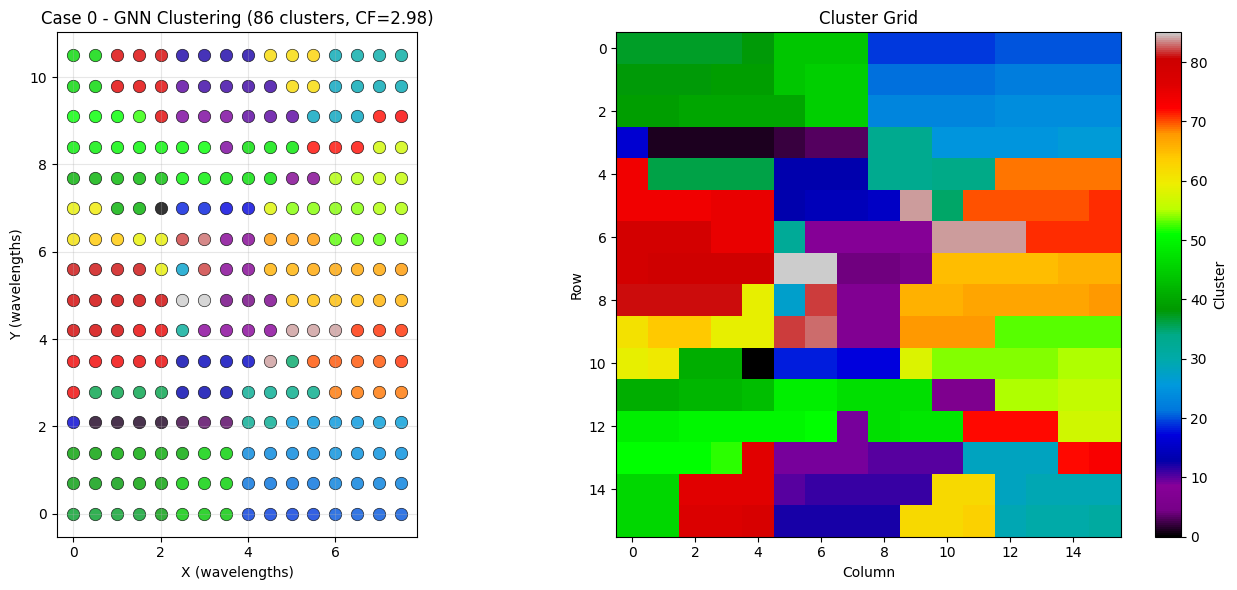


--- Radiation Pattern Evaluation ---


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


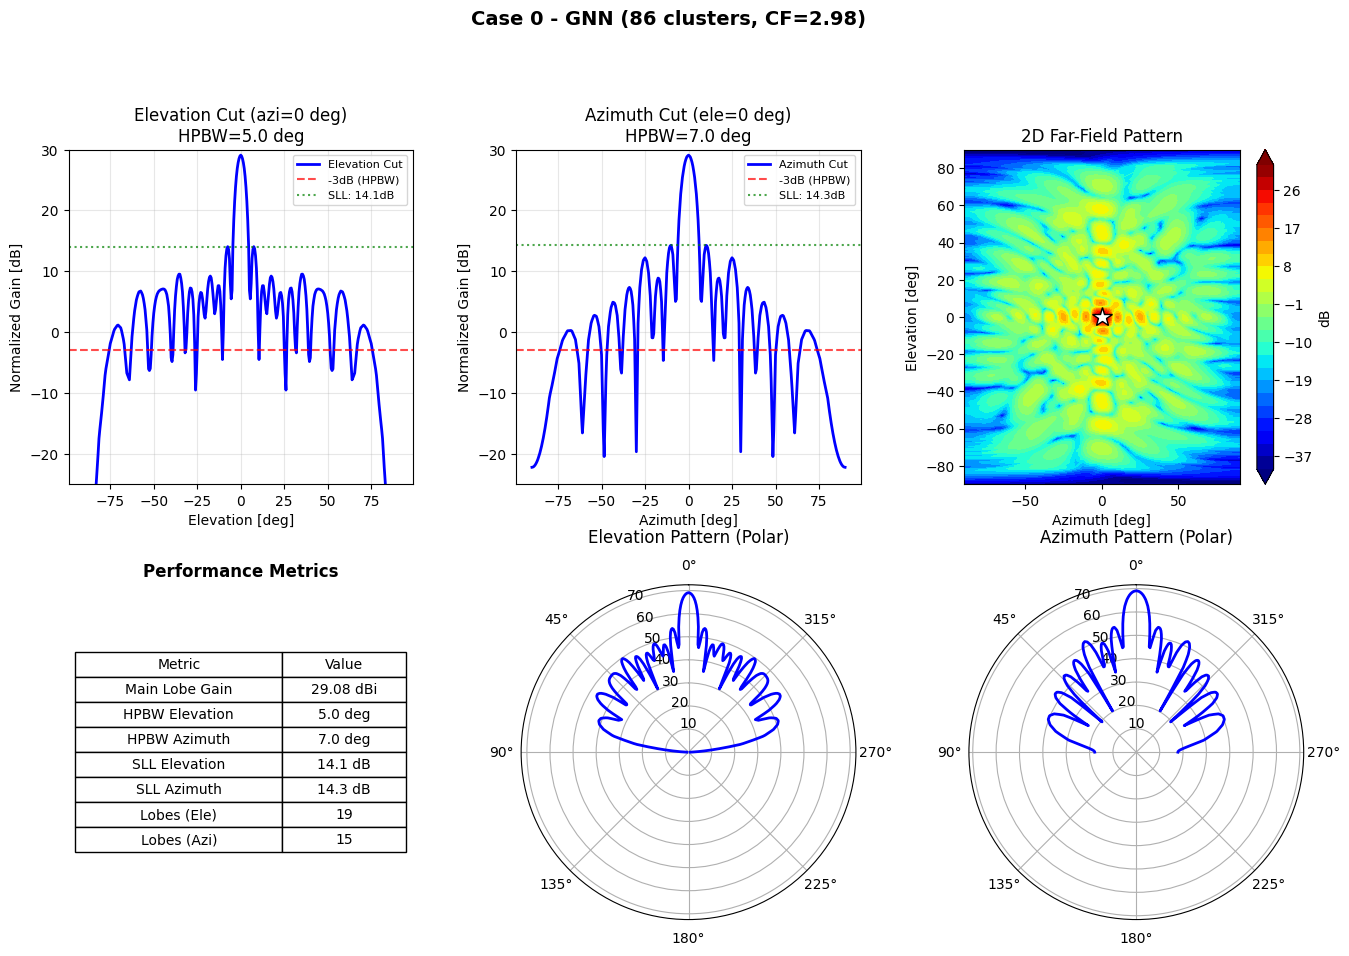


CASE 0 RESULTS:
  Cm: 19.80, CF: 2.98, SLL_out: -19.50dB, SLL_in: -14.89dB
  Hardware reduction: 66.4%

CASE 0: GNN vs MC/GA COMPARISON

  Metric                           GNN         MC       Diff
  -------------------------------------------------------
  HW reduction (%)                66.4       53.9      +12.5
  Cm (cost)                      19.80      19.76       +0.2%
  SLL_out (dB)                  -19.50     -18.29      -1.22 dB
  SLL_in (dB)                   -14.89     -11.66      -3.23 dB

  Metric                           GNN         GA       Diff
  -------------------------------------------------------
  HW reduction (%)                66.4       50.0      +16.4
  Cm (cost)                      19.80      19.77       +0.1%
  SLL_out (dB)                  -19.50     -17.83      -1.68 dB
  SLL_in (dB)                   -14.89     -11.43      -3.45 dB


In [8]:
# ============================================================
# CASE 0: theta=0 deg, phi=0 deg, target CF=2, SLL < -20dB
#         cluster sizes restricted to {1, 2, 4}
# ============================================================

print("="*70)
print("CASE 0: theta=0 deg, phi=0 deg, target CF=2, SLL<-20dB, sizes {1,2,4}")
print("="*70)

# Configuration
config_c0 = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)
target_cf_c0 = 2.0

print(f"Array: {config_c0.N} elements")
print(f"Target CF: {target_cf_c0}")
print(f"Allowed cluster sizes: [1, 2, 4]")

# Train GNN with allowed_sizes constraint
print("\nTraining GNN (physics-informed, allowed_sizes=[1,2,4])...")
clusters_c0 = train_ura_clustering(
    config_c0, target_cf=target_cf_c0, epochs=2000,
    allowed_sizes=[1, 2, 4], verbose=True
)

num_clusters_c0 = len(np.unique(clusters_c0))
sizes_c0 = np.bincount(clusters_c0)
print(f"\nClusters: {num_clusters_c0}, CF: {config_c0.N / num_clusters_c0:.2f}")
print(f"Cluster sizes: {dict(zip(*np.unique(sizes_c0, return_counts=True)))}")

# --- Cluster visualization ---
positions_c0, _, _, _ = create_ura_graph(config_c0, use_coupling=False)
pos_np_c0 = positions_c0.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_c0 = plt.cm.nipy_spectral if num_clusters_c0 > 20 else plt.cm.tab20 if num_clusters_c0 > 10 else plt.cm.tab10
colors_c0 = cmap_c0(np.linspace(0, 1, num_clusters_c0))

for k in range(num_clusters_c0):
    mask = clusters_c0 == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np_c0[mask, 0], pos_np_c0[mask, 1],
                        c=[colors_c0[k % len(colors_c0)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'Case 0 - GNN Clustering ({num_clusters_c0} clusters, CF={config_c0.N/num_clusters_c0:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

grid_c0 = clusters_c0.reshape(config_c0.rows, config_c0.cols)
im = axes[1].imshow(grid_c0, cmap='nipy_spectral' if num_clusters_c0 > 10 else 'tab10',
                    vmin=0, vmax=num_clusters_c0-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

# Radiation pattern evaluation
print("\n--- Radiation Pattern Evaluation ---")
lattice_c0 = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_c0 = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask_c0 = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=20)
eef_c0 = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_c0 = AntennaArray(lattice_c0, system_c0, mask_c0, eef_c0)

clusters_antenna_c0 = assignments_to_antenna_format(clusters_c0, grid_shape=(config_c0.rows, config_c0.cols))
result_c0 = array_c0.evaluate_clustering(clusters_antenna_c0)
metrics_c0 = plot_lobe_analysis(result_c0['FF_I_dB'], array_c0,
                                G_boresight=result_c0['G_boresight'],
                                title=f"Case 0 - GNN ({num_clusters_c0} clusters, CF={config_c0.N/num_clusters_c0:.2f})")

print(f"\nCASE 0 RESULTS:")
print(f"  Cm: {result_c0['Cm']:.2f}, CF: {result_c0['clustering_factor']:.2f}, SLL_out: {result_c0['sll_out']:.2f}dB, SLL_in: {result_c0['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters_c0/config_c0.N)*100:.1f}%")

# --- Comparison with MC/GA Case 0 ---
import json as _cmp_json
_ckpt_path = _os.path.join(_CHECKPOINT_DIR, "clustering_case_0.json")
if _os.path.exists(_ckpt_path):
    with open(_ckpt_path) as _f:
        _ckpt = _cmp_json.load(_f)
    _mc = _ckpt["steps"]["mc_optimization"]
    _ga = _ckpt["steps"]["ga_optimization"]

    gnn_hw = (1 - num_clusters_c0 / config_c0.N) * 100
    gnn_cm = result_c0['Cm']
    gnn_sll_out = result_c0['sll_out']
    gnn_sll_in = result_c0['sll_in']
    gnn_g = result_c0['G_boresight']

    print("\n" + "="*70)
    print("CASE 0: GNN vs MC/GA COMPARISON")
    print("="*70)

    # MC comparison
    if _mc["best_Cm"] is not None:
        mc_hw = (1 - _mc["best_Ntrans"] / config_c0.N) * 100
        mc_cm = _mc["best_Cm"]
        mc_sll_out = _mc["sll_out"]
        mc_sll_in = _mc["sll_in"]
        print(f"\n  {'Metric':<25} {'GNN':>10} {'MC':>10} {'Diff':>10}")
        print(f"  {'-'*55}")
        print(f"  {'HW reduction (%)':<25} {gnn_hw:>10.1f} {mc_hw:>10.1f} {gnn_hw - mc_hw:>+10.1f}")
        print(f"  {'Cm (cost)':<25} {gnn_cm:>10.2f} {mc_cm:>10.2f} {(gnn_cm - mc_cm)/abs(mc_cm)*100 if mc_cm else 0:>+10.1f}%")
        print(f"  {'SLL_out (dB)':<25} {gnn_sll_out:>10.2f} {mc_sll_out:>10.2f} {gnn_sll_out - mc_sll_out:>+10.2f} dB")
        print(f"  {'SLL_in (dB)':<25} {gnn_sll_in:>10.2f} {mc_sll_in:>10.2f} {gnn_sll_in - mc_sll_in:>+10.2f} dB")

    # GA comparison
    if _ga["best_Cm"] is not None:
        ga_hw = (1 - _ga["best_n_clusters"] / config_c0.N) * 100
        ga_cm = _ga["best_Cm"]
        ga_sll_out = _ga["sll_out"]
        ga_sll_in = _ga["sll_in"]
        print(f"\n  {'Metric':<25} {'GNN':>10} {'GA':>10} {'Diff':>10}")
        print(f"  {'-'*55}")
        print(f"  {'HW reduction (%)':<25} {gnn_hw:>10.1f} {ga_hw:>10.1f} {gnn_hw - ga_hw:>+10.1f}")
        print(f"  {'Cm (cost)':<25} {gnn_cm:>10.2f} {ga_cm:>10.2f} {(gnn_cm - ga_cm)/abs(ga_cm)*100 if ga_cm else 0:>+10.1f}%")
        print(f"  {'SLL_out (dB)':<25} {gnn_sll_out:>10.2f} {ga_sll_out:>10.2f} {gnn_sll_out - ga_sll_out:>+10.2f} dB")
        print(f"  {'SLL_in (dB)':<25} {gnn_sll_in:>10.2f} {ga_sll_in:>10.2f} {gnn_sll_in - ga_sll_in:>+10.2f} dB")
else:
    print("\nNOTE: Run clustering_comparison.ipynb Case 0 first to enable GNN vs MC/GA comparison.")

In [9]:
# --- Save Case 0 checkpoint ---
save_checkpoint("gnn_case_0.json", "gnn", "case_0",
    f"theta=0, phi=0, target CF={target_cf_c0}, SLL<-20dB, sizes={{1,2,4}}",
    {
        "config": {
            "rows": config_c0.rows, "cols": config_c0.cols,
            "dx": config_c0.dx, "dy": config_c0.dy,
            "freq_ghz": config_c0.freq / 1e9, "target_cf": target_cf_c0,
            "num_clusters": num_clusters_c0,
            "allowed_sizes": [1, 2, 4],
            "ele0": 0, "azi0": 0, "SLL_level": 20, "SLLin": 20,
        },
        "training": {
            "cluster_assignments": clusters_c0,
            "cluster_sizes": sizes_c0.tolist(),
            "num_clusters": num_clusters_c0,
            "clustering_factor": config_c0.N / num_clusters_c0,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_c0, metrics_c0, array_c0),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_case_0.json


## Case 1: theta=10 deg, phi=0 deg, target CF=2, SLL<-20dB

CASE 1: theta=10 deg, phi=0 deg, target CF=2, SLL<-20dB
Array: 256 elements
Target CF: 2.0

Training GNN (physics-informed)...
Epoch 100: Loss=1.6060 T=4.68 | clusters=106, CF=2.42, sizes: min=1, max=6, mean=2.4 | cut=-0.893, cf=0.000, bal=0.005
Epoch 200: Loss=1.6141 T=4.36 | clusters=108, CF=2.37, sizes: min=1, max=8, mean=2.4 | cut=-0.869, cf=0.001, bal=0.007
Epoch 300: Loss=1.6232 T=4.04 | clusters=102, CF=2.51, sizes: min=1, max=10, mean=2.5 | cut=-0.855, cf=0.001, bal=0.009
Epoch 400: Loss=1.6389 T=3.72 | clusters=105, CF=2.44, sizes: min=1, max=6, mean=2.4 | cut=-0.835, cf=0.001, bal=0.010
Epoch 500: Loss=1.6762 T=3.40 | clusters=107, CF=2.39, sizes: min=1, max=6, mean=2.4 | cut=-0.784, cf=0.001, bal=0.010
Epoch 600: Loss=1.7263 T=3.07 | clusters=98, CF=2.61, sizes: min=1, max=7, mean=2.6 | cut=-0.725, cf=0.001, bal=0.010
Epoch 700: Loss=1.7987 T=2.75 | clusters=108, CF=2.37, sizes: min=1, max=7, mean=2.4 | cut=-0.635, cf=0.001, bal=0.012
Epoch 800: Loss=1.8507 T=2.43 | clusters

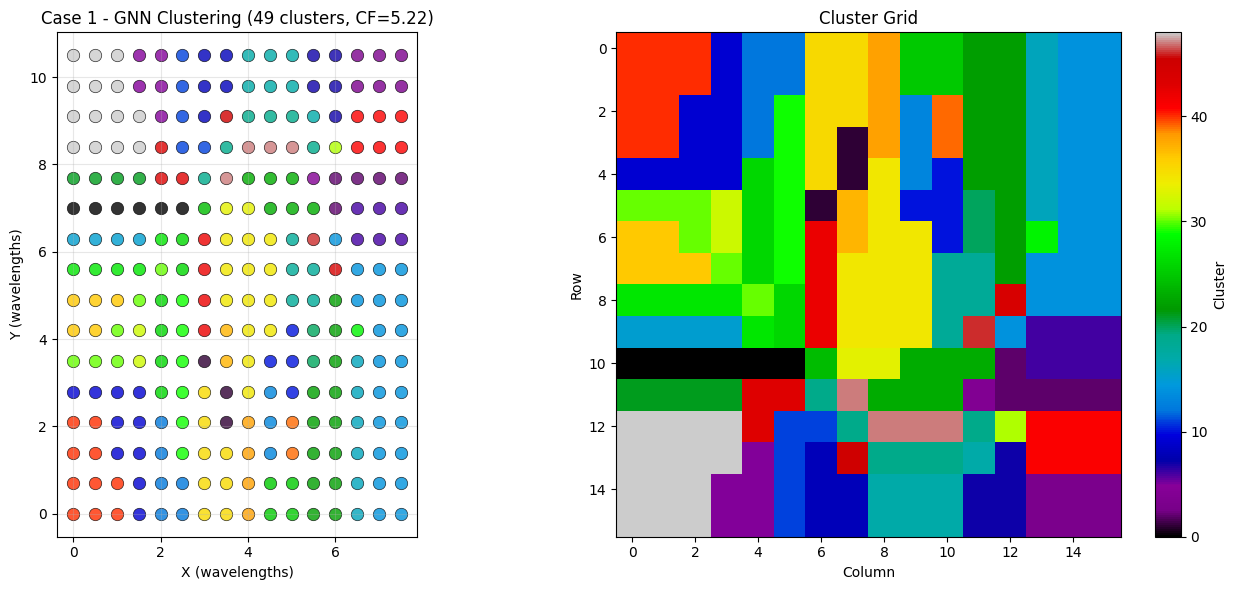


--- Radiation Pattern Evaluation ---


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


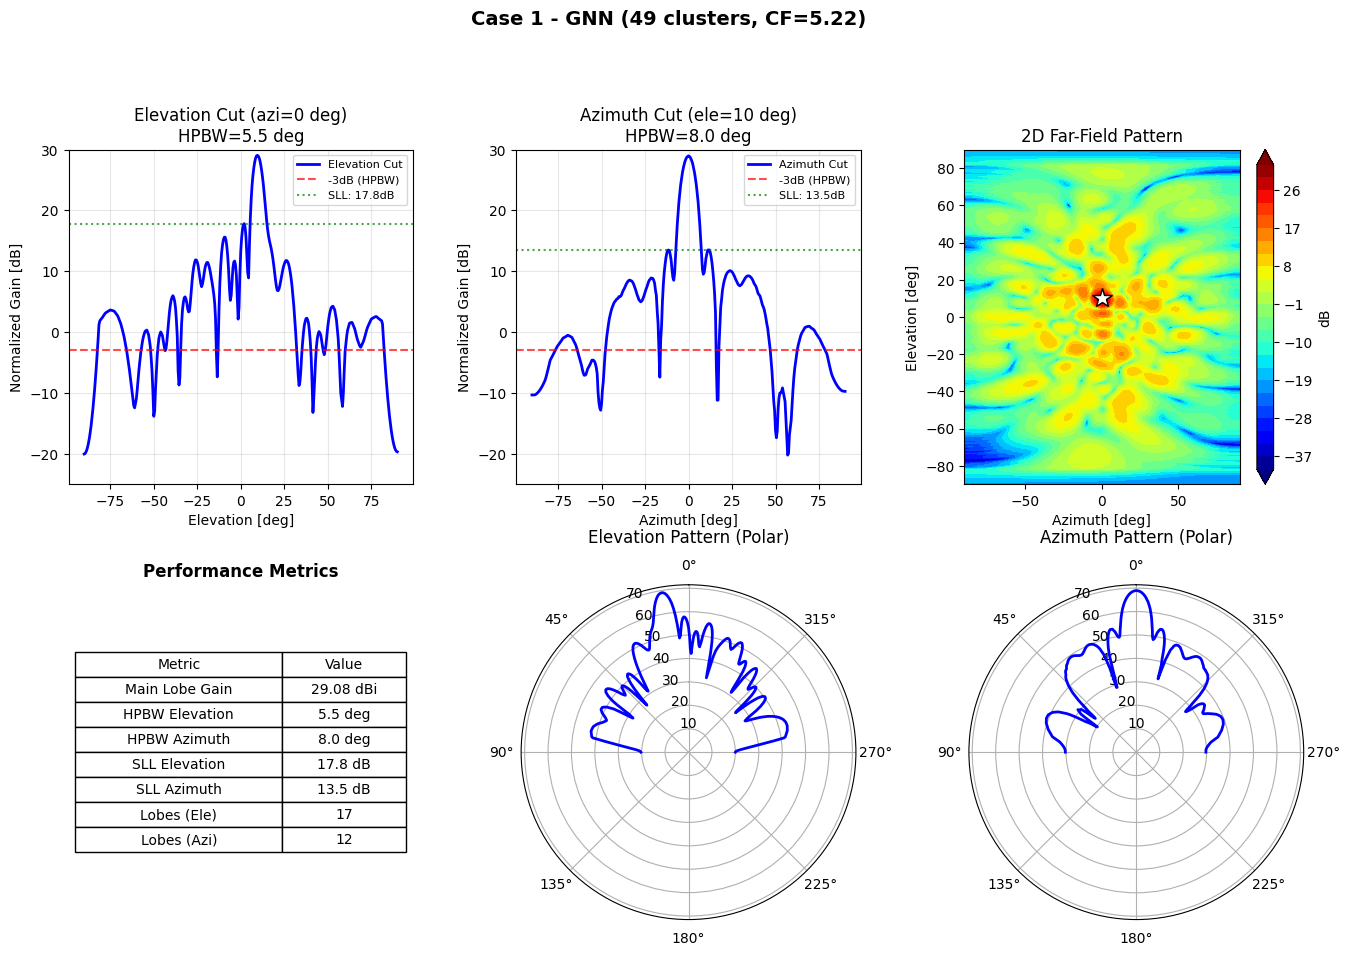


CASE 1 RESULTS:
  Cm: 19.83, CF: 5.22, SLL_out: -14.91dB, SLL_in: -12.29dB
  Hardware reduction: 80.9%


In [10]:
# ============================================================
# CASE 1: theta=10 deg, phi=0 deg, target CF=2, SLL < -20dB
# ============================================================

print("="*70)
print("CASE 1: theta=10 deg, phi=0 deg, target CF=2, SLL<-20dB")
print("="*70)

# Configuration
config_c1 = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)
target_cf_c1 = 2.0

print(f"Array: {config_c1.N} elements")
print(f"Target CF: {target_cf_c1}")

# Train GNN
print("\nTraining GNN (physics-informed)...")
clusters_c1 = train_ura_clustering(
    config_c1, target_cf=target_cf_c1, epochs=2000, verbose=True
)

num_clusters_c1 = len(np.unique(clusters_c1))
sizes_c1 = np.bincount(clusters_c1)
print(f"\nClusters: {num_clusters_c1}, CF: {config_c1.N / num_clusters_c1:.2f}")

# --- Cluster visualization ---
positions_c1, _, _, _ = create_ura_graph(config_c1, use_coupling=False)
pos_np_c1 = positions_c1.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_c1 = plt.cm.nipy_spectral if num_clusters_c1 > 20 else plt.cm.tab20 if num_clusters_c1 > 10 else plt.cm.tab10
colors_c1 = cmap_c1(np.linspace(0, 1, num_clusters_c1))

for k in range(num_clusters_c1):
    mask = clusters_c1 == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np_c1[mask, 0], pos_np_c1[mask, 1],
                        c=[colors_c1[k % len(colors_c1)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'Case 1 - GNN Clustering ({num_clusters_c1} clusters, CF={config_c1.N/num_clusters_c1:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

grid_c1 = clusters_c1.reshape(config_c1.rows, config_c1.cols)
im = axes[1].imshow(grid_c1, cmap='nipy_spectral' if num_clusters_c1 > 10 else 'tab10',
                    vmin=0, vmax=num_clusters_c1-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

# Radiation pattern evaluation
print("\n--- Radiation Pattern Evaluation ---")
lattice_c1 = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_c1 = SystemConfig(freq=29.5e9, azi0=0, ele0=10, dele=0.5, dazi=0.5)
mask_c1 = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=20)
eef_c1 = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_c1 = AntennaArray(lattice_c1, system_c1, mask_c1, eef_c1)

clusters_antenna_c1 = assignments_to_antenna_format(clusters_c1, grid_shape=(config_c1.rows, config_c1.cols))
result_c1 = array_c1.evaluate_clustering(clusters_antenna_c1)
metrics_c1 = plot_lobe_analysis(result_c1['FF_I_dB'], array_c1,
                                G_boresight=result_c1['G_boresight'],
                                title=f"Case 1 - GNN ({num_clusters_c1} clusters, CF={config_c1.N/num_clusters_c1:.2f})")

print(f"\nCASE 1 RESULTS:")
print(f"  Cm: {result_c1['Cm']:.2f}, CF: {result_c1['clustering_factor']:.2f}, SLL_out: {result_c1['sll_out']:.2f}dB, SLL_in: {result_c1['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters_c1/config_c1.N)*100:.1f}%")

In [11]:
# --- Save Case 1 checkpoint ---
save_checkpoint("gnn_case_1.json", "gnn", "case_1",
    f"theta=10, phi=0, target CF={target_cf_c1}, SLL<-20dB",
    {
        "config": {
            "rows": config_c1.rows, "cols": config_c1.cols,
            "dx": config_c1.dx, "dy": config_c1.dy,
            "freq_ghz": config_c1.freq / 1e9, "target_cf": target_cf_c1,
            "num_clusters": num_clusters_c1,
            "ele0": 10, "azi0": 0, "SLL_level": 20, "SLLin": 20,
        },
        "training": {
            "cluster_assignments": clusters_c1,
            "cluster_sizes": sizes_c1.tolist(),
            "num_clusters": num_clusters_c1,
            "clustering_factor": config_c1.N / num_clusters_c1,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_c1, metrics_c1, array_c1),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_case_1.json


## Case 2: theta=0 deg, phi=60 deg, target CF=2, SLL<-20dB

CASE 2: theta=0 deg, phi=60 deg, target CF=2, SLL<-20dB
Array: 256 elements
Target CF: 2.0

Training GNN (physics-informed)...
Epoch 100: Loss=1.5947 T=4.68 | clusters=99, CF=2.59, sizes: min=1, max=7, mean=2.6 | cut=-0.894, cf=0.000, bal=0.004
Epoch 200: Loss=1.5960 T=4.36 | clusters=106, CF=2.42, sizes: min=1, max=7, mean=2.4 | cut=-0.873, cf=0.000, bal=0.005
Epoch 300: Loss=1.6078 T=4.04 | clusters=106, CF=2.42, sizes: min=1, max=7, mean=2.4 | cut=-0.852, cf=0.000, bal=0.006
Epoch 400: Loss=1.6259 T=3.72 | clusters=105, CF=2.44, sizes: min=1, max=6, mean=2.4 | cut=-0.827, cf=0.000, bal=0.006
Epoch 500: Loss=1.6637 T=3.40 | clusters=109, CF=2.35, sizes: min=1, max=6, mean=2.3 | cut=-0.780, cf=0.000, bal=0.007
Epoch 600: Loss=1.7555 T=3.07 | clusters=106, CF=2.42, sizes: min=1, max=7, mean=2.4 | cut=-0.675, cf=0.000, bal=0.008
Epoch 700: Loss=1.7806 T=2.75 | clusters=107, CF=2.39, sizes: min=1, max=7, mean=2.4 | cut=-0.636, cf=0.000, bal=0.009
Epoch 800: Loss=1.8194 T=2.43 | clusters=

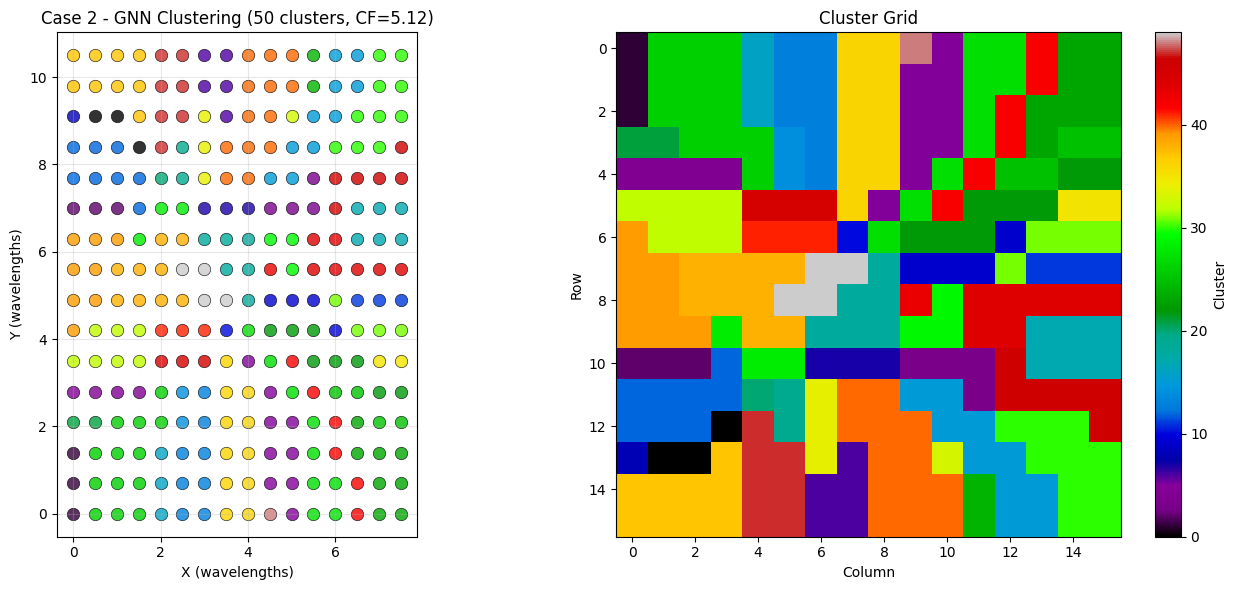


--- Radiation Pattern Evaluation ---


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


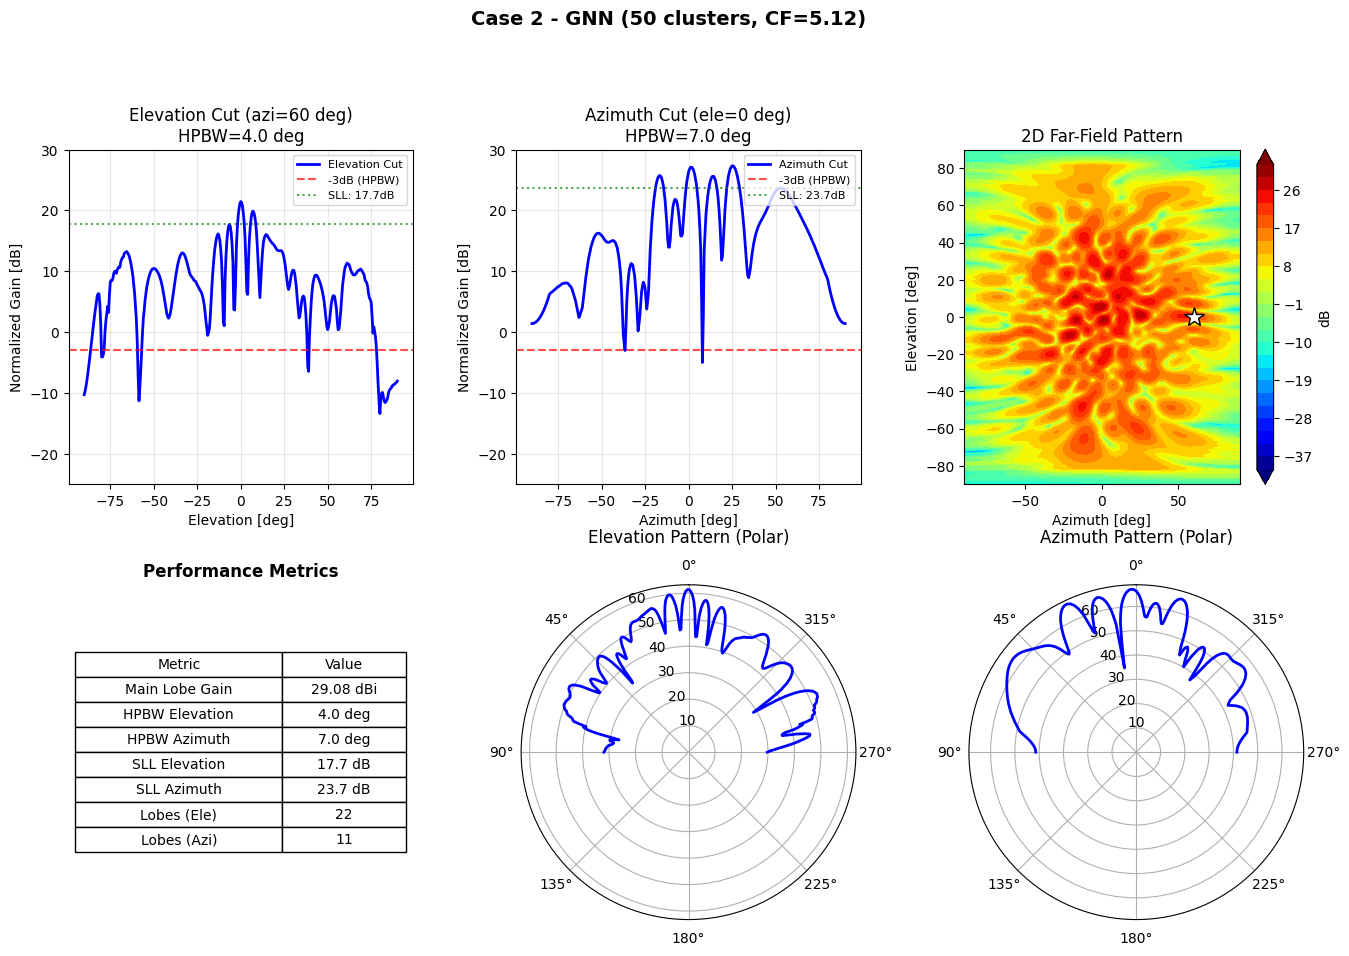


CASE 2 RESULTS:
  Cm: 19.85, CF: 5.12, SLL_out: -0.14dB, SLL_in: -1.15dB
  Hardware reduction: 80.5%


In [12]:
# ============================================================
# CASE 2: theta=0 deg, phi=60 deg, target CF=2, SLL < -20dB
# ============================================================

print("="*70)
print("CASE 2: theta=0 deg, phi=60 deg, target CF=2, SLL<-20dB")
print("="*70)

# Configuration
config_c2 = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)
target_cf_c2 = 2.0

print(f"Array: {config_c2.N} elements")
print(f"Target CF: {target_cf_c2}")

# Train GNN
print("\nTraining GNN (physics-informed)...")
clusters_c2 = train_ura_clustering(
    config_c2, target_cf=target_cf_c2, epochs=2000, verbose=True
)

num_clusters_c2 = len(np.unique(clusters_c2))
sizes_c2 = np.bincount(clusters_c2)
print(f"\nClusters: {num_clusters_c2}, CF: {config_c2.N / num_clusters_c2:.2f}")

# --- Cluster visualization ---
positions_c2, _, _, _ = create_ura_graph(config_c2, use_coupling=False)
pos_np_c2 = positions_c2.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_c2 = plt.cm.nipy_spectral if num_clusters_c2 > 20 else plt.cm.tab20 if num_clusters_c2 > 10 else plt.cm.tab10
colors_c2 = cmap_c2(np.linspace(0, 1, num_clusters_c2))

for k in range(num_clusters_c2):
    mask = clusters_c2 == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np_c2[mask, 0], pos_np_c2[mask, 1],
                        c=[colors_c2[k % len(colors_c2)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'Case 2 - GNN Clustering ({num_clusters_c2} clusters, CF={config_c2.N/num_clusters_c2:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

grid_c2 = clusters_c2.reshape(config_c2.rows, config_c2.cols)
im = axes[1].imshow(grid_c2, cmap='nipy_spectral' if num_clusters_c2 > 10 else 'tab10',
                    vmin=0, vmax=num_clusters_c2-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

# Radiation pattern evaluation
print("\n--- Radiation Pattern Evaluation ---")
lattice_c2 = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_c2 = SystemConfig(freq=29.5e9, azi0=60, ele0=0, dele=0.5, dazi=0.5)
mask_c2 = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=20)
eef_c2 = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_c2 = AntennaArray(lattice_c2, system_c2, mask_c2, eef_c2)

clusters_antenna_c2 = assignments_to_antenna_format(clusters_c2, grid_shape=(config_c2.rows, config_c2.cols))
result_c2 = array_c2.evaluate_clustering(clusters_antenna_c2)
metrics_c2 = plot_lobe_analysis(result_c2['FF_I_dB'], array_c2,
                                G_boresight=result_c2['G_boresight'],
                                title=f"Case 2 - GNN ({num_clusters_c2} clusters, CF={config_c2.N/num_clusters_c2:.2f})")

print(f"\nCASE 2 RESULTS:")
print(f"  Cm: {result_c2['Cm']:.2f}, CF: {result_c2['clustering_factor']:.2f}, SLL_out: {result_c2['sll_out']:.2f}dB, SLL_in: {result_c2['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters_c2/config_c2.N)*100:.1f}%")

In [13]:
# --- Save Case 2 checkpoint ---
save_checkpoint("gnn_case_2.json", "gnn", "case_2",
    f"theta=0, phi=60, target CF={target_cf_c2}, SLL<-20dB",
    {
        "config": {
            "rows": config_c2.rows, "cols": config_c2.cols,
            "dx": config_c2.dx, "dy": config_c2.dy,
            "freq_ghz": config_c2.freq / 1e9, "target_cf": target_cf_c2,
            "num_clusters": num_clusters_c2,
            "ele0": 0, "azi0": 60, "SLL_level": 20, "SLLin": 20,
        },
        "training": {
            "cluster_assignments": clusters_c2,
            "cluster_sizes": sizes_c2.tolist(),
            "num_clusters": num_clusters_c2,
            "clustering_factor": config_c2.N / num_clusters_c2,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_c2, metrics_c2, array_c2),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_case_2.json


## Case 3: theta=10 deg, phi=45 deg, target CF=4, SLL<-20dB

CASE 3: theta=10 deg, phi=45 deg, target CF=4, SLL<-20dB
Array: 256 elements
Target CF: 4.0

Training GNN (physics-informed)...
Epoch 100: Loss=4.5120 T=4.68 | clusters=90, CF=2.84, sizes: min=1, max=7, mean=2.8 | cut=-0.897, cf=0.250, bal=0.111
Epoch 200: Loss=4.5265 T=4.36 | clusters=91, CF=2.81, sizes: min=1, max=7, mean=2.8 | cut=-0.879, cf=0.250, bal=0.111
Epoch 300: Loss=4.5439 T=4.04 | clusters=90, CF=2.84, sizes: min=1, max=10, mean=2.8 | cut=-0.856, cf=0.250, bal=0.111
Epoch 400: Loss=4.5537 T=3.72 | clusters=92, CF=2.78, sizes: min=1, max=7, mean=2.8 | cut=-0.841, cf=0.250, bal=0.111
Epoch 500: Loss=4.5932 T=3.40 | clusters=87, CF=2.94, sizes: min=1, max=7, mean=2.9 | cut=-0.791, cf=0.250, bal=0.112
Epoch 600: Loss=4.6300 T=3.07 | clusters=89, CF=2.88, sizes: min=1, max=6, mean=2.9 | cut=-0.742, cf=0.250, bal=0.112
Epoch 700: Loss=4.6917 T=2.75 | clusters=93, CF=2.75, sizes: min=1, max=6, mean=2.8 | cut=-0.659, cf=0.250, bal=0.112
Epoch 800: Loss=4.7561 T=2.43 | clusters=87, 

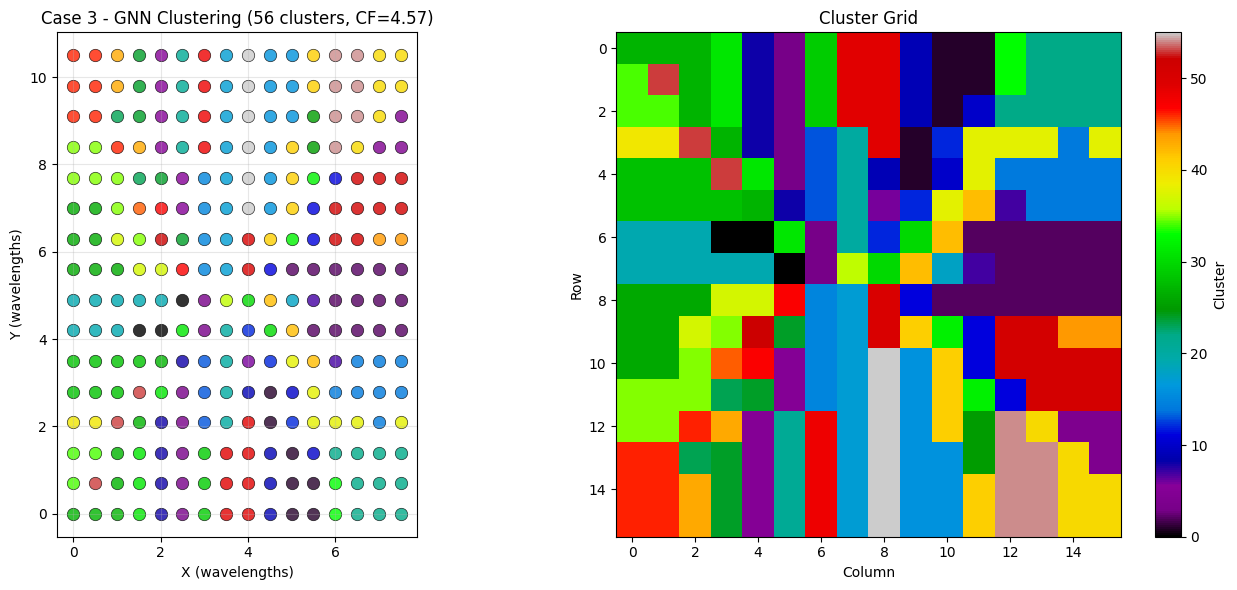


--- Radiation Pattern Evaluation ---


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


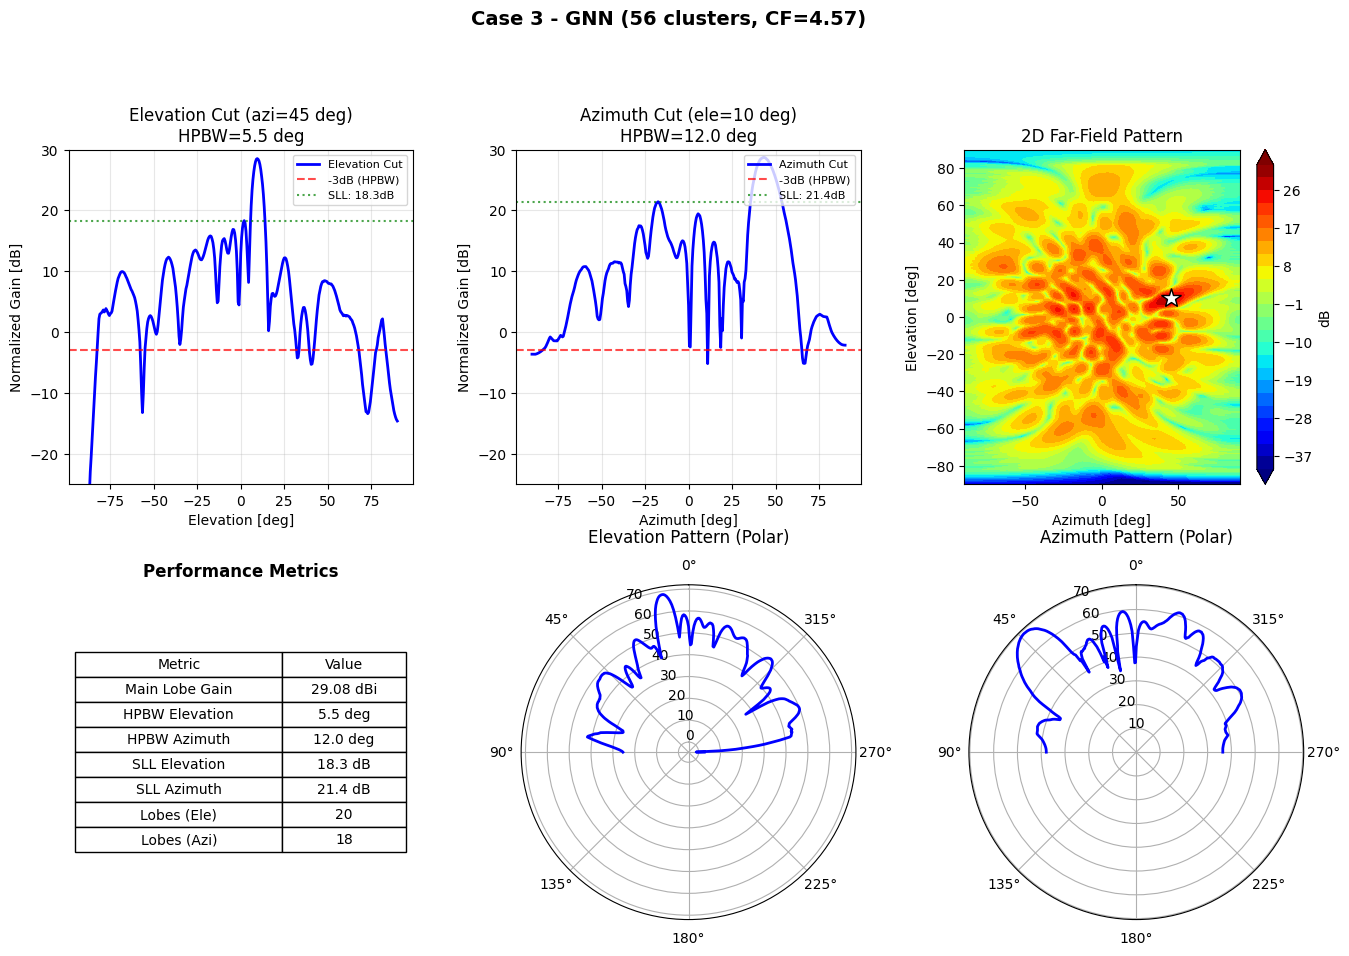


CASE 3 RESULTS:
  Cm: 19.90, CF: 4.57, SLL_out: -5.48dB, SLL_in: -5.36dB
  Hardware reduction: 78.1%


In [14]:
# ============================================================
# CASE 3: theta=10 deg, phi=45 deg, target CF=4, SLL < -20dB
# ============================================================

print("="*70)
print("CASE 3: theta=10 deg, phi=45 deg, target CF=4, SLL<-20dB")
print("="*70)

# Configuration
config_c3 = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)
target_cf_c3 = 4.0

print(f"Array: {config_c3.N} elements")
print(f"Target CF: {target_cf_c3}")

# Train GNN
print("\nTraining GNN (physics-informed)...")
clusters_c3 = train_ura_clustering(
    config_c3, target_cf=target_cf_c3, epochs=2000, verbose=True
)

num_clusters_c3 = len(np.unique(clusters_c3))
sizes_c3 = np.bincount(clusters_c3)
print(f"\nClusters: {num_clusters_c3}, CF: {config_c3.N / num_clusters_c3:.2f}")

# --- Cluster visualization ---
positions_c3, _, _, _ = create_ura_graph(config_c3, use_coupling=False)
pos_np_c3 = positions_c3.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_c3 = plt.cm.nipy_spectral if num_clusters_c3 > 20 else plt.cm.tab20 if num_clusters_c3 > 10 else plt.cm.tab10
colors_c3 = cmap_c3(np.linspace(0, 1, num_clusters_c3))

for k in range(num_clusters_c3):
    mask = clusters_c3 == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np_c3[mask, 0], pos_np_c3[mask, 1],
                        c=[colors_c3[k % len(colors_c3)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'Case 3 - GNN Clustering ({num_clusters_c3} clusters, CF={config_c3.N/num_clusters_c3:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

grid_c3 = clusters_c3.reshape(config_c3.rows, config_c3.cols)
im = axes[1].imshow(grid_c3, cmap='nipy_spectral' if num_clusters_c3 > 10 else 'tab10',
                    vmin=0, vmax=num_clusters_c3-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

# Radiation pattern evaluation
print("\n--- Radiation Pattern Evaluation ---")
lattice_c3 = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_c3 = SystemConfig(freq=29.5e9, azi0=45, ele0=10, dele=0.5, dazi=0.5)
mask_c3 = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=20)
eef_c3 = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_c3 = AntennaArray(lattice_c3, system_c3, mask_c3, eef_c3)

clusters_antenna_c3 = assignments_to_antenna_format(clusters_c3, grid_shape=(config_c3.rows, config_c3.cols))
result_c3 = array_c3.evaluate_clustering(clusters_antenna_c3)
metrics_c3 = plot_lobe_analysis(result_c3['FF_I_dB'], array_c3,
                                G_boresight=result_c3['G_boresight'],
                                title=f"Case 3 - GNN ({num_clusters_c3} clusters, CF={config_c3.N/num_clusters_c3:.2f})")

print(f"\nCASE 3 RESULTS:")
print(f"  Cm: {result_c3['Cm']:.2f}, CF: {result_c3['clustering_factor']:.2f}, SLL_out: {result_c3['sll_out']:.2f}dB, SLL_in: {result_c3['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters_c3/config_c3.N)*100:.1f}%")

In [15]:
# --- Save Case 3 checkpoint ---
save_checkpoint("gnn_case_3.json", "gnn", "case_3",
    f"theta=10, phi=45, target CF={target_cf_c3}, SLL<-20dB",
    {
        "config": {
            "rows": config_c3.rows, "cols": config_c3.cols,
            "dx": config_c3.dx, "dy": config_c3.dy,
            "freq_ghz": config_c3.freq / 1e9, "target_cf": target_cf_c3,
            "num_clusters": num_clusters_c3,
            "ele0": 10, "azi0": 45, "SLL_level": 20, "SLLin": 20,
        },
        "training": {
            "cluster_assignments": clusters_c3,
            "cluster_sizes": sizes_c3.tolist(),
            "num_clusters": num_clusters_c3,
            "clustering_factor": config_c3.N / num_clusters_c3,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_c3, metrics_c3, array_c3),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_case_3.json


## Case 4: theta=10 deg, phi=45 deg, target CF=4, SLL<-15dB

CASE 4: theta=10 deg, phi=45 deg, target CF=4, SLL<-15dB
Array: 256 elements
Target CF: 4.0

Training GNN (physics-informed)...
Epoch 100: Loss=4.5142 T=4.68 | clusters=89, CF=2.88, sizes: min=1, max=7, mean=2.9 | cut=-0.894, cf=0.250, bal=0.111
Epoch 200: Loss=4.5236 T=4.36 | clusters=87, CF=2.94, sizes: min=1, max=6, mean=2.9 | cut=-0.881, cf=0.250, bal=0.111
Epoch 300: Loss=4.5426 T=4.04 | clusters=89, CF=2.88, sizes: min=1, max=8, mean=2.9 | cut=-0.858, cf=0.250, bal=0.111
Epoch 400: Loss=4.5841 T=3.72 | clusters=91, CF=2.81, sizes: min=1, max=7, mean=2.8 | cut=-0.807, cf=0.250, bal=0.111
Epoch 500: Loss=4.6066 T=3.40 | clusters=91, CF=2.81, sizes: min=1, max=7, mean=2.8 | cut=-0.776, cf=0.250, bal=0.112
Epoch 600: Loss=4.6671 T=3.07 | clusters=89, CF=2.88, sizes: min=1, max=8, mean=2.9 | cut=-0.702, cf=0.250, bal=0.112
Epoch 700: Loss=4.7086 T=2.75 | clusters=92, CF=2.78, sizes: min=1, max=8, mean=2.8 | cut=-0.637, cf=0.250, bal=0.112
Epoch 800: Loss=4.7724 T=2.43 | clusters=87, C

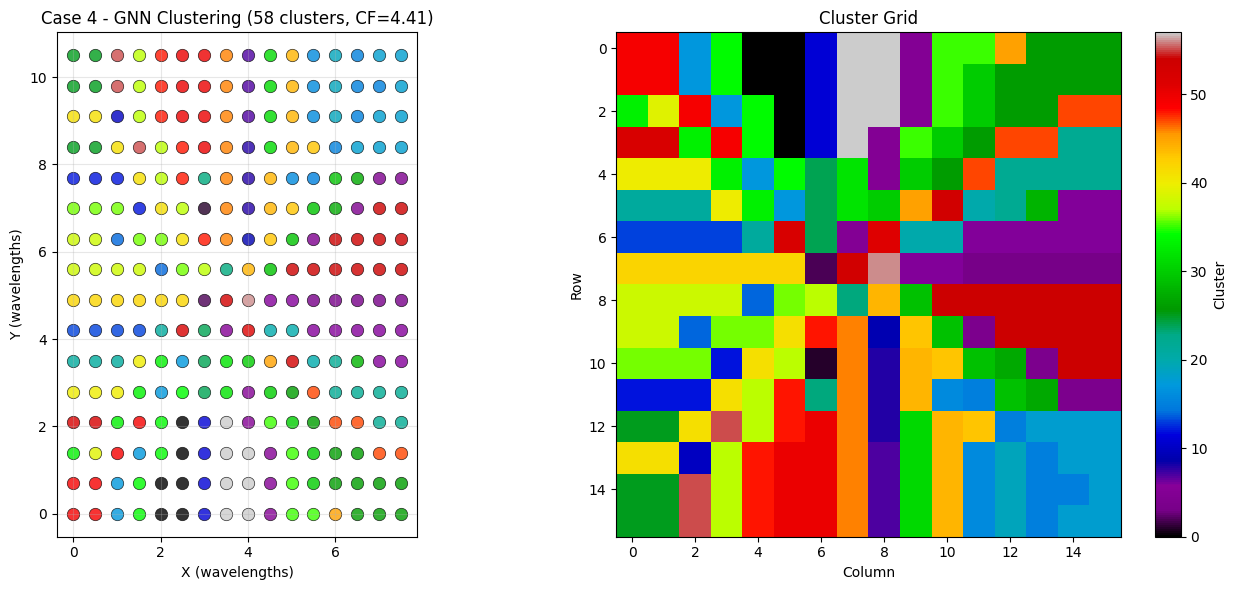


--- Radiation Pattern Evaluation ---


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


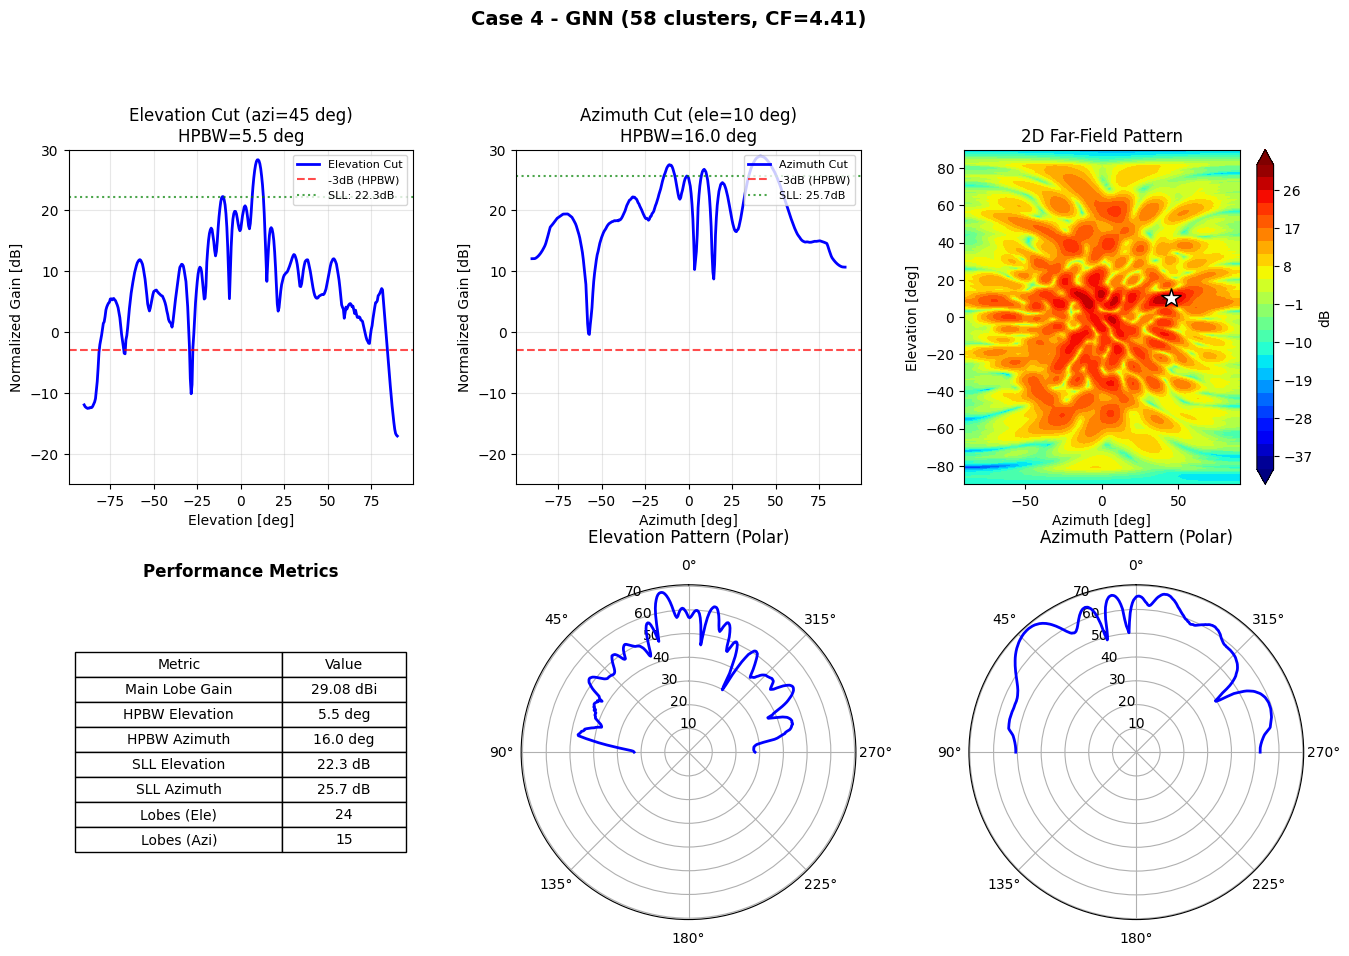


CASE 4 RESULTS:
  Cm: 14.92, CF: 4.41, SLL_out: -2.44dB, SLL_in: -0.97dB
  Hardware reduction: 77.3%


In [16]:
# ============================================================
# CASE 4: theta=10 deg, phi=45 deg, target CF=4, SLL < -15dB
# ============================================================

print("="*70)
print("CASE 4: theta=10 deg, phi=45 deg, target CF=4, SLL<-15dB")
print("="*70)

# Configuration
config_c4 = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)
target_cf_c4 = 4.0

print(f"Array: {config_c4.N} elements")
print(f"Target CF: {target_cf_c4}")

# Train GNN
print("\nTraining GNN (physics-informed)...")
clusters_c4 = train_ura_clustering(
    config_c4, target_cf=target_cf_c4, epochs=2000, verbose=True
)

num_clusters_c4 = len(np.unique(clusters_c4))
sizes_c4 = np.bincount(clusters_c4)
print(f"\nClusters: {num_clusters_c4}, CF: {config_c4.N / num_clusters_c4:.2f}")

# --- Cluster visualization ---
positions_c4, _, _, _ = create_ura_graph(config_c4, use_coupling=False)
pos_np_c4 = positions_c4.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_c4 = plt.cm.nipy_spectral if num_clusters_c4 > 20 else plt.cm.tab20 if num_clusters_c4 > 10 else plt.cm.tab10
colors_c4 = cmap_c4(np.linspace(0, 1, num_clusters_c4))

for k in range(num_clusters_c4):
    mask = clusters_c4 == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np_c4[mask, 0], pos_np_c4[mask, 1],
                        c=[colors_c4[k % len(colors_c4)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'Case 4 - GNN Clustering ({num_clusters_c4} clusters, CF={config_c4.N/num_clusters_c4:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

grid_c4 = clusters_c4.reshape(config_c4.rows, config_c4.cols)
im = axes[1].imshow(grid_c4, cmap='nipy_spectral' if num_clusters_c4 > 10 else 'tab10',
                    vmin=0, vmax=num_clusters_c4-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

# Radiation pattern evaluation
print("\n--- Radiation Pattern Evaluation ---")
lattice_c4 = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_c4 = SystemConfig(freq=29.5e9, azi0=45, ele0=10, dele=0.5, dazi=0.5)
mask_c4 = MaskConfig(elem=30, azim=60, SLL_level=15, SLLin=15)
eef_c4 = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_c4 = AntennaArray(lattice_c4, system_c4, mask_c4, eef_c4)

clusters_antenna_c4 = assignments_to_antenna_format(clusters_c4, grid_shape=(config_c4.rows, config_c4.cols))
result_c4 = array_c4.evaluate_clustering(clusters_antenna_c4)
metrics_c4 = plot_lobe_analysis(result_c4['FF_I_dB'], array_c4,
                                G_boresight=result_c4['G_boresight'],
                                title=f"Case 4 - GNN ({num_clusters_c4} clusters, CF={config_c4.N/num_clusters_c4:.2f})")

print(f"\nCASE 4 RESULTS:")
print(f"  Cm: {result_c4['Cm']:.2f}, CF: {result_c4['clustering_factor']:.2f}, SLL_out: {result_c4['sll_out']:.2f}dB, SLL_in: {result_c4['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters_c4/config_c4.N)*100:.1f}%")

In [17]:
# --- Save Case 4 checkpoint ---
save_checkpoint("gnn_case_4.json", "gnn", "case_4",
    f"theta=10, phi=45, target CF={target_cf_c4}, SLL<-15dB",
    {
        "config": {
            "rows": config_c4.rows, "cols": config_c4.cols,
            "dx": config_c4.dx, "dy": config_c4.dy,
            "freq_ghz": config_c4.freq / 1e9, "target_cf": target_cf_c4,
            "num_clusters": num_clusters_c4,
            "ele0": 10, "azi0": 45, "SLL_level": 15, "SLLin": 15,
        },
        "training": {
            "cluster_assignments": clusters_c4,
            "cluster_sizes": sizes_c4.tolist(),
            "num_clusters": num_clusters_c4,
            "clustering_factor": config_c4.N / num_clusters_c4,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_c4, metrics_c4, array_c4),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_case_4.json


## Case 5: theta=0 deg, phi=0 deg, target CF=8

CASE 5: theta=0 deg, phi=0 deg, target CF=8
Array: 256 elements
Target CF: 8.0

Training GNN (physics-informed)...
Epoch 100: Loss=4.1609 T=4.68 | clusters=48, CF=5.33, sizes: min=1, max=9, mean=5.3 | cut=-0.903, cf=0.250, bal=0.111
Epoch 200: Loss=4.1759 T=4.36 | clusters=47, CF=5.45, sizes: min=2, max=10, mean=5.4 | cut=-0.883, cf=0.250, bal=0.111
Epoch 300: Loss=4.1901 T=4.04 | clusters=48, CF=5.33, sizes: min=2, max=9, mean=5.3 | cut=-0.864, cf=0.250, bal=0.111
Epoch 400: Loss=4.2257 T=3.72 | clusters=47, CF=5.45, sizes: min=2, max=11, mean=5.4 | cut=-0.821, cf=0.250, bal=0.112
Epoch 500: Loss=4.2524 T=3.40 | clusters=48, CF=5.33, sizes: min=1, max=12, mean=5.3 | cut=-0.785, cf=0.250, bal=0.112
Epoch 600: Loss=4.2857 T=3.07 | clusters=48, CF=5.33, sizes: min=2, max=11, mean=5.3 | cut=-0.740, cf=0.250, bal=0.112
Epoch 700: Loss=4.3454 T=2.75 | clusters=48, CF=5.33, sizes: min=2, max=11, mean=5.3 | cut=-0.661, cf=0.250, bal=0.112
Epoch 800: Loss=4.2922 T=2.43 | clusters=48, CF=5.33, 

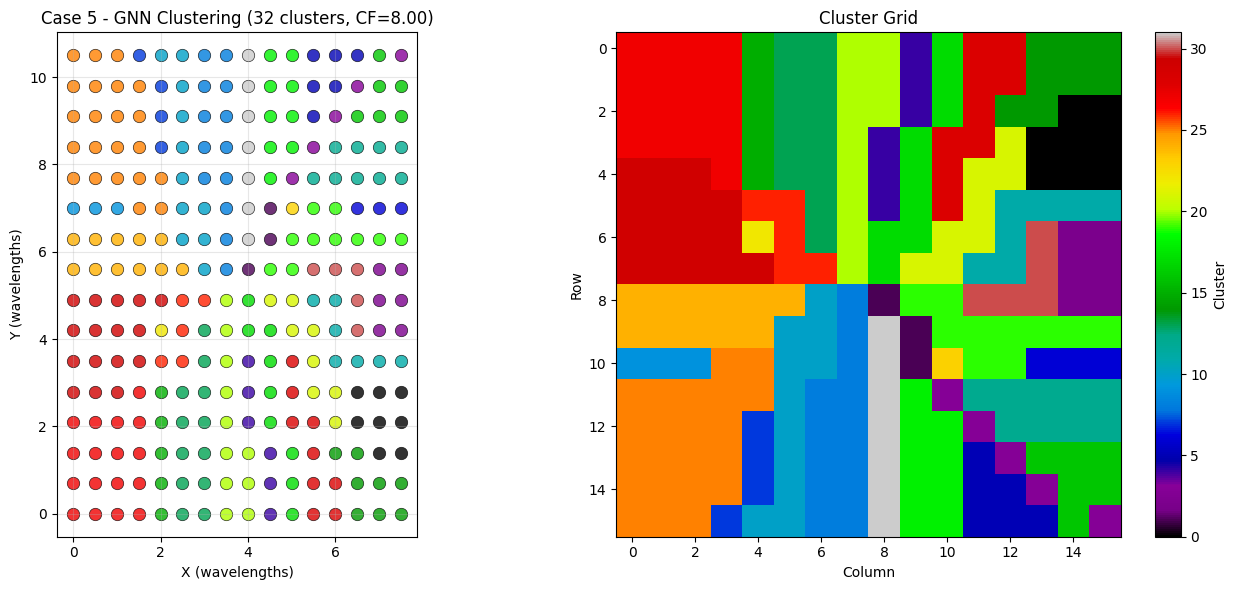


--- Radiation Pattern Evaluation ---


C:\Users\Andrea\AppData\Local\Temp\ipykernel_10908\1733064739.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


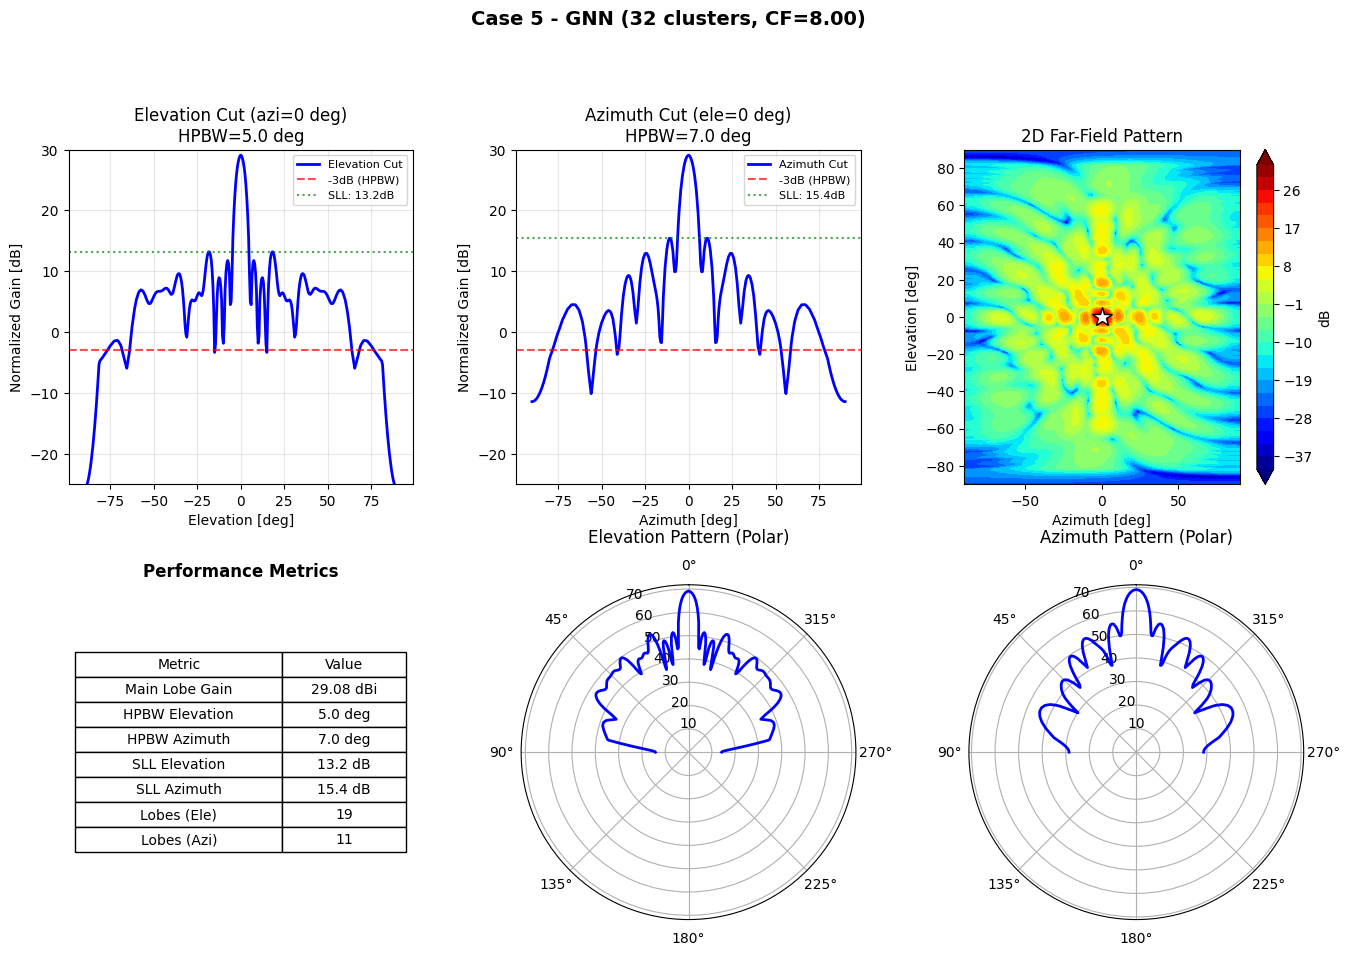


CASE 5 RESULTS:
  Cm: 14.81, CF: 8.00, SLL_out: -19.46dB, SLL_in: -13.58dB
  Hardware reduction: 87.5%


In [18]:
# ============================================================
# CASE 5: theta=0 deg, phi=0 deg, target CF=8
# ============================================================

print("="*70)
print("CASE 5: theta=0 deg, phi=0 deg, target CF=8")
print("="*70)

# Configuration
config_c5 = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=29.5)
target_cf_c5 = 8.0

print(f"Array: {config_c5.N} elements")
print(f"Target CF: {target_cf_c5}")

# Train GNN
print("\nTraining GNN (physics-informed)...")
clusters_c5 = train_ura_clustering(
    config_c5, target_cf=target_cf_c5, epochs=2000, verbose=True
)

num_clusters_c5 = len(np.unique(clusters_c5))
sizes_c5 = np.bincount(clusters_c5)
print(f"\nClusters: {num_clusters_c5}, CF: {config_c5.N / num_clusters_c5:.2f}")

# --- Cluster visualization ---
positions_c5, _, _, _ = create_ura_graph(config_c5, use_coupling=False)
pos_np_c5 = positions_c5.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cmap_c5 = plt.cm.nipy_spectral if num_clusters_c5 > 20 else plt.cm.tab20 if num_clusters_c5 > 10 else plt.cm.tab10
colors_c5 = cmap_c5(np.linspace(0, 1, num_clusters_c5))

for k in range(num_clusters_c5):
    mask = clusters_c5 == k
    if mask.sum() > 0:
        axes[0].scatter(pos_np_c5[mask, 0], pos_np_c5[mask, 1],
                        c=[colors_c5[k % len(colors_c5)]], s=80,
                        alpha=0.8, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('X (wavelengths)')
axes[0].set_ylabel('Y (wavelengths)')
axes[0].set_title(f'Case 5 - GNN Clustering ({num_clusters_c5} clusters, CF={config_c5.N/num_clusters_c5:.2f})')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

grid_c5 = clusters_c5.reshape(config_c5.rows, config_c5.cols)
im = axes[1].imshow(grid_c5, cmap='nipy_spectral' if num_clusters_c5 > 10 else 'tab10',
                    vmin=0, vmax=num_clusters_c5-1)
axes[1].set_title('Cluster Grid')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im, ax=axes[1], label='Cluster')
plt.tight_layout()
plt.show()

# Radiation pattern evaluation
print("\n--- Radiation Pattern Evaluation ---")
lattice_c5 = LatticeConfig(Nz=16, Ny=16, dist_z=0.7, dist_y=0.5, lattice_type=1)
system_c5 = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask_c5 = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef_c5 = ElementPatternConfig(P=1, Gel=5, load_file=0)
array_c5 = AntennaArray(lattice_c5, system_c5, mask_c5, eef_c5)

clusters_antenna_c5 = assignments_to_antenna_format(clusters_c5, grid_shape=(config_c5.rows, config_c5.cols))
result_c5 = array_c5.evaluate_clustering(clusters_antenna_c5)
metrics_c5 = plot_lobe_analysis(result_c5['FF_I_dB'], array_c5,
                                G_boresight=result_c5['G_boresight'],
                                title=f"Case 5 - GNN ({num_clusters_c5} clusters, CF={config_c5.N/num_clusters_c5:.2f})")

print(f"\nCASE 5 RESULTS:")
print(f"  Cm: {result_c5['Cm']:.2f}, CF: {result_c5['clustering_factor']:.2f}, SLL_out: {result_c5['sll_out']:.2f}dB, SLL_in: {result_c5['sll_in']:.2f}dB")
print(f"  Hardware reduction: {(1 - num_clusters_c5/config_c5.N)*100:.1f}%")

In [19]:
# --- Save Case 5 checkpoint ---
save_checkpoint("gnn_case_5.json", "gnn", "case_5",
    f"theta=0, phi=0, target CF={target_cf_c5}",
    {
        "config": {
            "rows": config_c5.rows, "cols": config_c5.cols,
            "dx": config_c5.dx, "dy": config_c5.dy,
            "freq_ghz": config_c5.freq / 1e9, "target_cf": target_cf_c5,
            "num_clusters": num_clusters_c5,
            "ele0": 0, "azi0": 0, "SLL_level": 20, "SLLin": 15,
        },
        "training": {
            "cluster_assignments": clusters_c5,
            "cluster_sizes": sizes_c5.tolist(),
            "num_clusters": num_clusters_c5,
            "clustering_factor": config_c5.N / num_clusters_c5,
            "epochs": 2000, "mode": "physics-informed",
        },
        "radiation": _build_radiation_step(result_c5, metrics_c5, array_c5),
    }
)

Checkpoint saved: c:\Users\Andrea\Desktop\antenna-clustering\irregular\intermediate_steps\gnn_case_5.json
